# Q2: Out-of-Distribution Detection

Evaluate 6 OOD scoring methods across training epochs:
- Output-based: MSP, MaxLogit, Energy
- Distance-based: Mahalanobis  
- Feature-based: ViM, NECO (TPT only)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
if not os.path.exists('/content/OOD-Detection-Project---CSC_5IA23'):
    !git clone https://github.com/DiegoFleury/OOD-Detection-Project---CSC_5IA23.git
%cd /content/OOD-Detection-Project---CSC_5IA23

Cloning into 'OOD-Detection-Project---CSC_5IA23'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 259 (delta 129), reused 199 (delta 79), pack-reused 0 (from 0)
Receiving objects: 100% (259/259), 4.37 MiB | 17.96 MiB/s, done.
Resolving deltas: 100% (129/129), done.
/content/OOD-Detection-Project---CSC_5IA23


In [3]:
# Install dependencies
!pip install -q torch torchvision matplotlib seaborn scikit-learn pyyaml imageio tqdm

In [4]:
import torch
import numpy as np
import yaml
import glob
import pickle
from tqdm import tqdm

from src.models import ResNet18
from src.data import get_cifar100_loaders, get_ood_loaders
from src.ood_scores import (
    MSPScorer, MaxLogitScorer, EnergyScorer,
    MahalanobisScorer, ViMScorer, NECOScorer
)
from src.utils.ood_metrics import compute_auroc, compute_fpr_at_tpr
from src.utils.visualization import plot_ood_scores_per_dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [5]:
# Load config
with open('configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print(yaml.dump(config,default_flow_style=False))

data:
  augment: true
  data_dir: ./data
  num_workers: 2
device: cuda
model:
  num_classes: 100
ood:
  datasets:
  - SVHN
  - CIFAR10
  - Textures
  sampling_ratio: 0.1
  tpt_mask:
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 1
  - 1
  - 1
  - 1
paths:
  checkpoints: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints
  figures: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures
  gifs: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/gifs
  metrics: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics
  ood_detection: /content/drive/MyDrive/Colab Notebooks/OOD/Results/ood_scoring
  results: /content/drive/MyDrive/Colab Notebooks/OOD/Results
  tables: /content/drive/MyDrive/Colab Notebooks/OOD/Results/tables
training:
  batch_size: 128
  checkpoint_frequency: 25
  early_stopping_patience: 999
  epochs: 300
  lr: 0.1
  momentum: 0.9
  val_split: 0.1
  weight_decay: 0.0005



In [6]:
# ID data (CIFAR-100 test)
_, _, id_test_loader = get_cifar100_loaders(
    data_dir=config['data']['data_dir'],
    batch_size=config['training']['batch_size'],
    num_workers=config['data']['num_workers']
)

# OOD data (proportional sampling)
ood_loaders = get_ood_loaders(
    ood_datasets=config['ood']['datasets'],
    data_dir=config['data']['data_dir'],
    batch_size=config['training']['batch_size'],
    num_workers=config['data']['num_workers'],
    sampling_ratio=config['ood']['sampling_ratio']
)

print(f"ID test samples: {len(id_test_loader.dataset)}")

print("OOD samples:")
for name, loader in ood_loaders.items():
    print(f"({name}) : {len(loader.dataset)}")

100%|██████████| 169M/169M [00:13<00:00, 13.0MB/s]
100%|██████████| 64.3M/64.3M [00:17<00:00, 3.61MB/s]
100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]
100%|██████████| 625M/625M [00:35<00:00, 17.5MB/s]


ID test samples: 10000
OOD samples:
(SVHN) : 2603
(CIFAR10) : 1000
(Textures) : 188


In [7]:
def initialize_scorers(model):
    return {
        'MSP': MSPScorer(model, device),
        'MaxLogit': MaxLogitScorer(model, device),
        'Energy': EnergyScorer(model, device),
        'Mahalanobis': MahalanobisScorer(model, device),
        'ViM': ViMScorer(model, device),
        'NECO': NECOScorer(model, device)
    }

In [8]:
# Extract epoch numbers
def get_epoch_num(path):
    import re
    match = re.search(r'epoch(\d+)', path)
    return int(match.group(1)) if match else 0

checkpoint_dir = config['paths']['checkpoints']
checkpoints = sorted(glob.glob(f"{checkpoint_dir}/resnet18_cifar100_epoch*.pth"), key = get_epoch_num)

checkpoint_epochs = [get_epoch_num(cp) for cp in checkpoints]
tpt_mask = config['ood']['tpt_mask']

# Results storage
results = {
    'config': {
        'epochs': checkpoint_epochs,
        'ood_datasets': config['ood']['datasets'],
        'sampling_ratio': config['ood']['sampling_ratio'],
        'tpt_mask': tpt_mask
    },
    'scorers': {}
}

# init structure for each ood dataset
for scorer_name in ['MSP', 'MaxLogit', 'Energy', 'Mahalanobis', 'ViM', 'NECO']:
    results['scorers'][scorer_name] = {}

    for ood_dataset in config['ood']['datasets']:
        results['scorers'][scorer_name][ood_dataset] = {
            'auroc': [],
            'fpr95': []
        }

print(f"\nEvaluating {len(checkpoints)} checkpoints...")
print(f"TPT mask: {tpt_mask}")


Evaluating 12 checkpoints...
TPT mask: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


In [9]:
checkpoints

['/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch25.pth',
 '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch50.pth',
 '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch75.pth',
 '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch100.pth',
 '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch125.pth',
 '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch150.pth',
 '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch175.pth',
 '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch200.pth',
 '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch225.pth',
 '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch250.pth',
 '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch275.pth',
 '/content/dr

In [10]:
for epoch_idx, (checkpoint_path, epoch) in enumerate(zip(checkpoints, checkpoint_epochs)):
    print(f"\n{'='*60}")
    print(f"Checkpoint: Epoch {epoch} ({epoch_idx+1}/{len(checkpoints)})")
    print('='*60)

    # Load model
    model = ResNet18(num_classes=config['model']['num_classes'])
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Initialize scorers
    scorers = initialize_scorers(model)

    # Fit statistics-based scorers (once per checkpoint)
    print("\nFitting statistics-based scorers...")
    train_loader, _, _ = get_cifar100_loaders(
        data_dir=config['data']['data_dir'],
        batch_size=config['training']['batch_size'],
        num_workers=config['data']['num_workers']
    )

    for name in ['Mahalanobis', 'ViM', 'NECO']:
        if name == 'NECO' and not tpt_mask[epoch_idx]:
            continue  # Skip NECO if not in TPT
        print(f"  Fitting {name}...")
        scorers[name].fit(train_loader, num_classes=config['model']['num_classes'])

    # Evaluate each scorer
    print("\nEvaluating scorers...")

    # Compute ID scores once (same for all OOD datasets)
    print("  Computing ID scores...")
    id_scores_dict = {}
    for scorer_name, scorer in scorers.items():
        if scorer_name == 'NECO' and not tpt_mask[epoch_idx]:
            continue
        id_scores_dict[scorer_name] = scorer.score_loader(id_test_loader)

    # Evaluate against each OOD dataset separately
    for dataset_name, ood_loader_single in ood_loaders.items():
        print(f"\n  OOD Dataset: {dataset_name}")

        for scorer_name, scorer in scorers.items():
            # Skip NECO if not in TPT
            if scorer_name == 'NECO' and not tpt_mask[epoch_idx]:
                if dataset_name == list(ood_loaders.keys())[0]:  # Print only once
                    print(f"    {scorer_name}: Skipped (not in TPT)")
                continue

            print(f"    {scorer_name}...", end=' ')

            # Get ID scores (already computed)
            id_scores = id_scores_dict[scorer_name]

            # Compute OOD scores for this dataset
            ood_scores = scorer.score_loader(ood_loader_single)

            # Compute metrics
            auroc = compute_auroc(id_scores, ood_scores)
            fpr95 = compute_fpr_at_tpr(id_scores, ood_scores, tpr_target=0.95)

            # Store results per dataset
            results['scorers'][scorer_name][dataset_name]['auroc'].append(auroc)
            results['scorers'][scorer_name][dataset_name]['fpr95'].append(fpr95)

            print(f"AUROC: {auroc:.3f}, FPR@95: {fpr95:.1f}%")


Checkpoint: Epoch 25 (1/12)

Fitting statistics-based scorers...
  Fitting Mahalanobis...
  Fitting ViM...

Evaluating scorers...
  Computing ID scores...

  OOD Dataset: SVHN
    MSP... AUROC: 0.596, FPR@95: 84.7%
    MaxLogit... AUROC: 0.677, FPR@95: 70.7%
    Energy... AUROC: 0.686, FPR@95: 69.2%
    Mahalanobis... AUROC: 0.713, FPR@95: 77.9%
    ViM... AUROC: 0.791, FPR@95: 66.6%
    NECO: Skipped (not in TPT)

  OOD Dataset: CIFAR10
    MSP... AUROC: 0.621, FPR@95: 81.5%
    MaxLogit... AUROC: 0.625, FPR@95: 84.7%
    Energy... AUROC: 0.622, FPR@95: 85.2%
    Mahalanobis... AUROC: 0.516, FPR@95: 90.3%
    ViM... AUROC: 0.602, FPR@95: 86.8%

  OOD Dataset: Textures
    MSP... AUROC: 0.579, FPR@95: 89.5%
    MaxLogit... AUROC: 0.618, FPR@95: 87.2%
    Energy... AUROC: 0.625, FPR@95: 86.9%
    Mahalanobis... AUROC: 0.631, FPR@95: 92.6%
    ViM... AUROC: 0.596, FPR@95: 85.5%

Checkpoint: Epoch 50 (2/12)

Fitting statistics-based scorers...
  Fitting Mahalanobis...
  Fitting ViM...

E

In [11]:
output_dir = config['paths']['ood_detection']
import os
os.makedirs(output_dir, exist_ok=True)

# Save pickle
results_path = os.path.join(output_dir, 'ood_scores_results.pkl')
with open(results_path, 'wb') as f:
    pickle.dump(results, f)
print(f"\nResults saved: {results_path}")

# Save CSV summary
import pandas as pd
summary_data = []

for scorer_name, datasets_dict in results['scorers'].items():
    for dataset_name, metrics in datasets_dict.items():
        if len(metrics['auroc']) > 0:
            summary_data.append({
                'Scorer': scorer_name,
                'OOD Dataset': dataset_name,
                'Final AUROC': metrics['auroc'][-1],
                'Final FPR@95': metrics['fpr95'][-1],
                'Epochs Evaluated': len(metrics['auroc'])
            })

df = pd.DataFrame(summary_data)
csv_path = os.path.join(output_dir, 'ood_scores_summary.csv')
df.to_csv(csv_path, index=False)
print(f"\nCSV summary saved: {csv_path}")
print("\n", df)

# Also save aggregated summary (average across datasets)
print("\n" + "="*60)
print("Aggregated Results (Average across OOD datasets)")
print("="*60)

agg_data = []
for scorer_name, datasets_dict in results['scorers'].items():
    aurocs = []
    fprs = []
    for dataset_name, metrics in datasets_dict.items():
        if len(metrics['auroc']) > 0:
            aurocs.append(metrics['auroc'][-1])
            fprs.append(metrics['fpr95'][-1])

    if aurocs:
        agg_data.append({
            'Scorer': scorer_name,
            'Avg AUROC': np.mean(aurocs),
            'Avg FPR@95': np.mean(fprs),
            'Std AUROC': np.std(aurocs),
            'Std FPR@95': np.std(fprs)
        })

df_agg = pd.DataFrame(agg_data)
agg_path = os.path.join(output_dir, 'ood_scores_aggregated.csv')
df_agg.to_csv(agg_path, index=False)
print(df_agg)


Results saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/ood_scoring/ood_scores_results.pkl

CSV summary saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/ood_scoring/ood_scores_summary.csv

          Scorer OOD Dataset  Final AUROC  Final FPR@95  Epochs Evaluated
0           MSP        SVHN     0.805627         51.65                12
1           MSP     CIFAR10     0.792337         56.83                12
2           MSP    Textures     0.787356         58.36                12
3      MaxLogit        SVHN     0.820998         49.27                12
4      MaxLogit     CIFAR10     0.795126         57.80                12
5      MaxLogit    Textures     0.797914         54.86                12
6        Energy        SVHN     0.826218         49.06                12
7        Energy     CIFAR10     0.794413         57.84                12
8        Energy    Textures     0.800978         54.53                12
9   Mahalanobis        SVHN     0.762871         59.14      

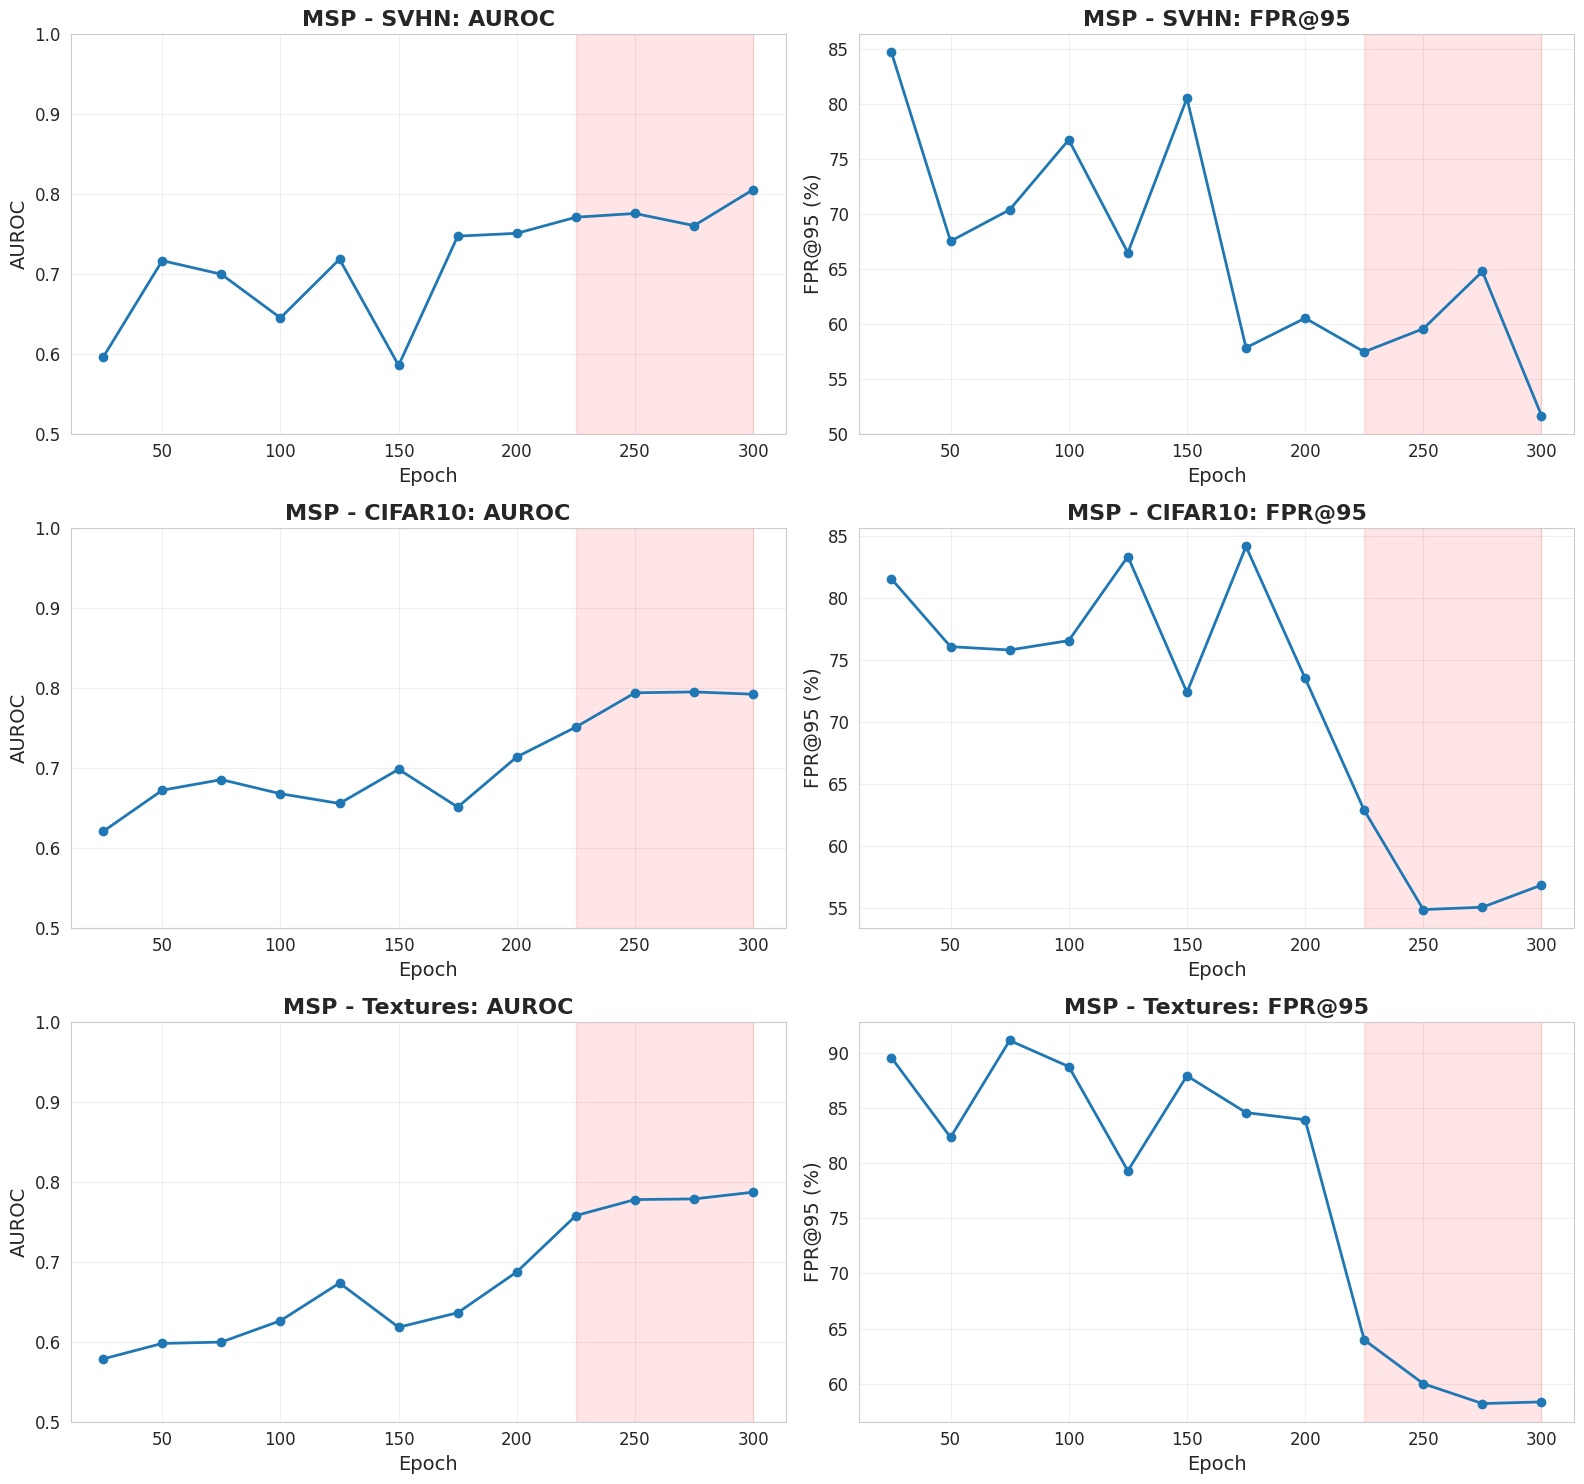

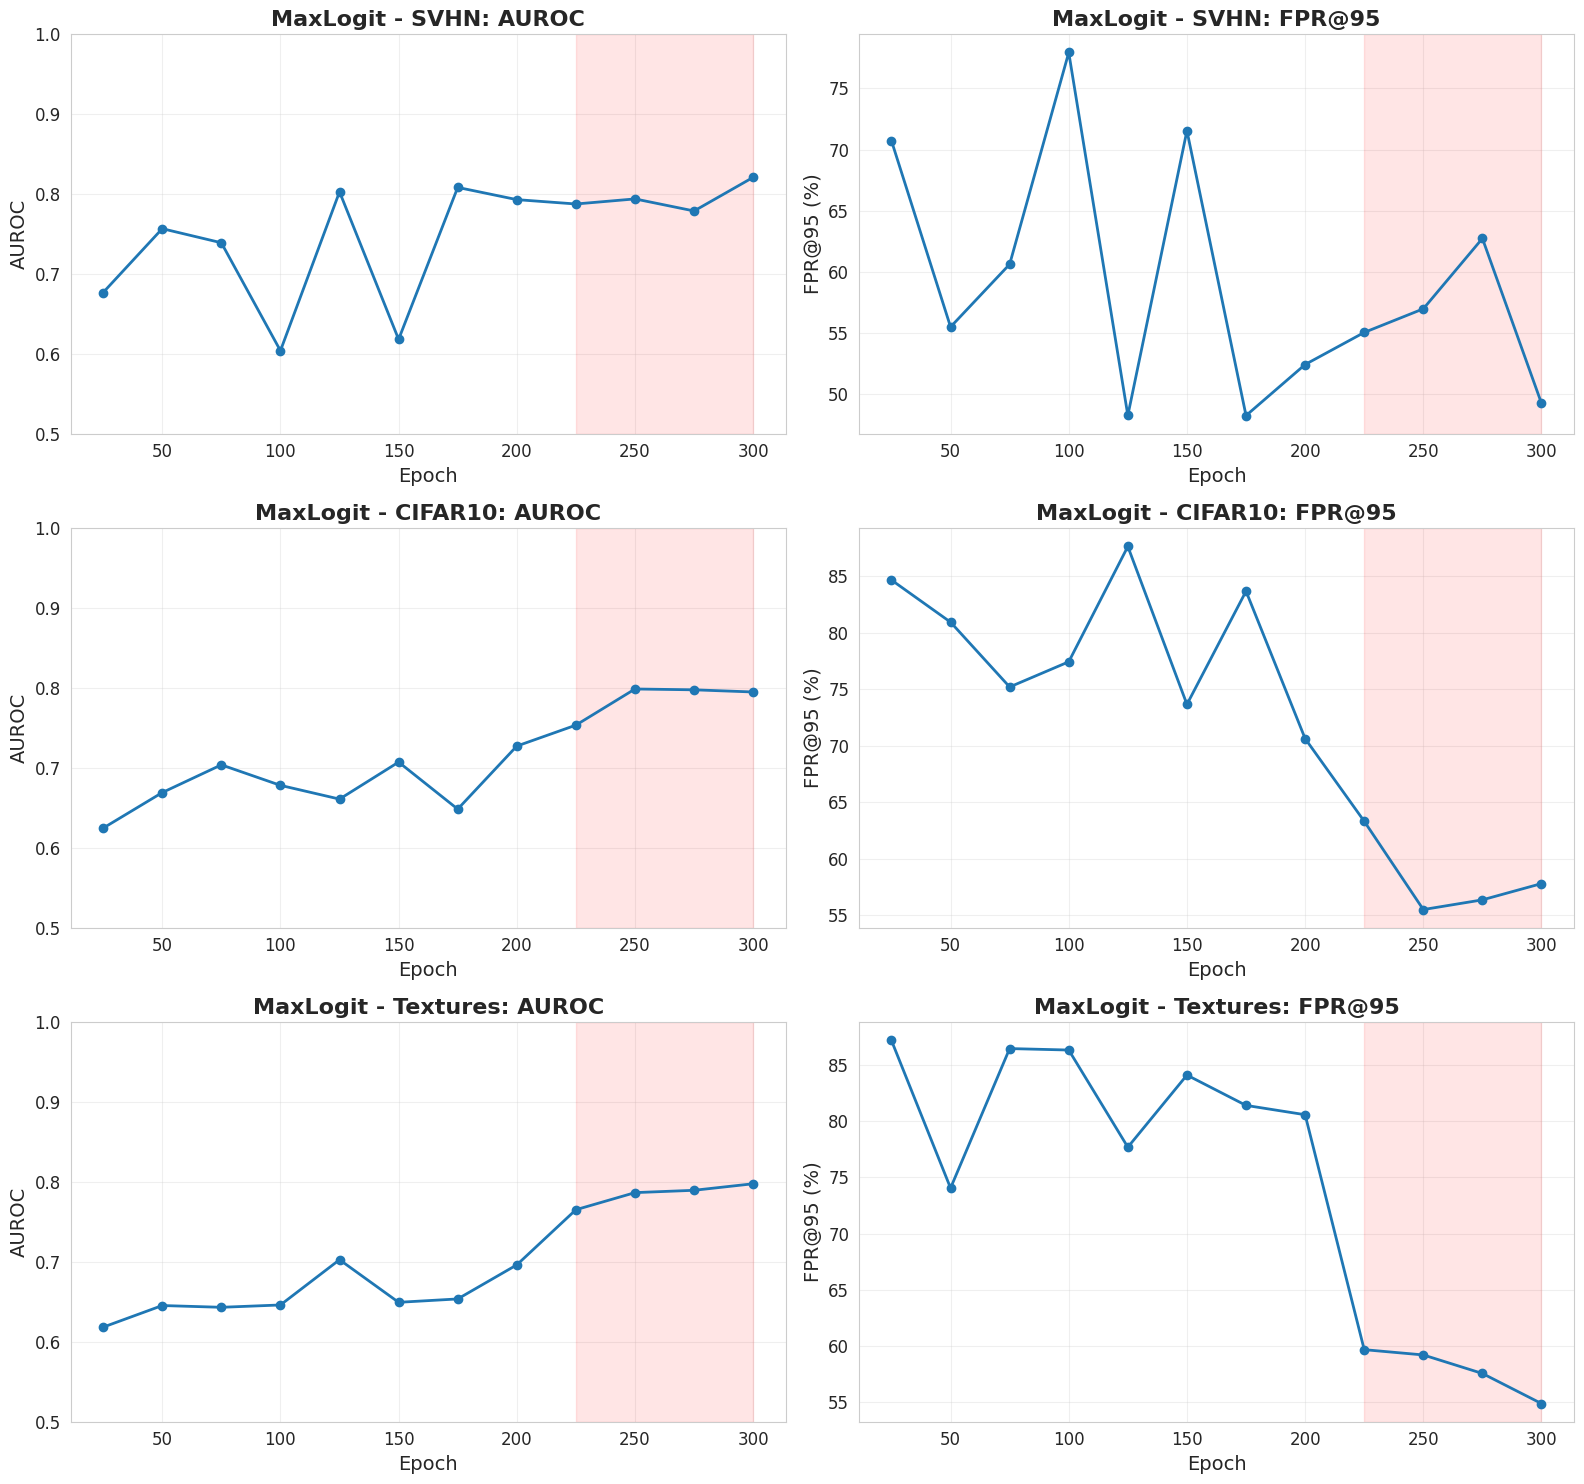

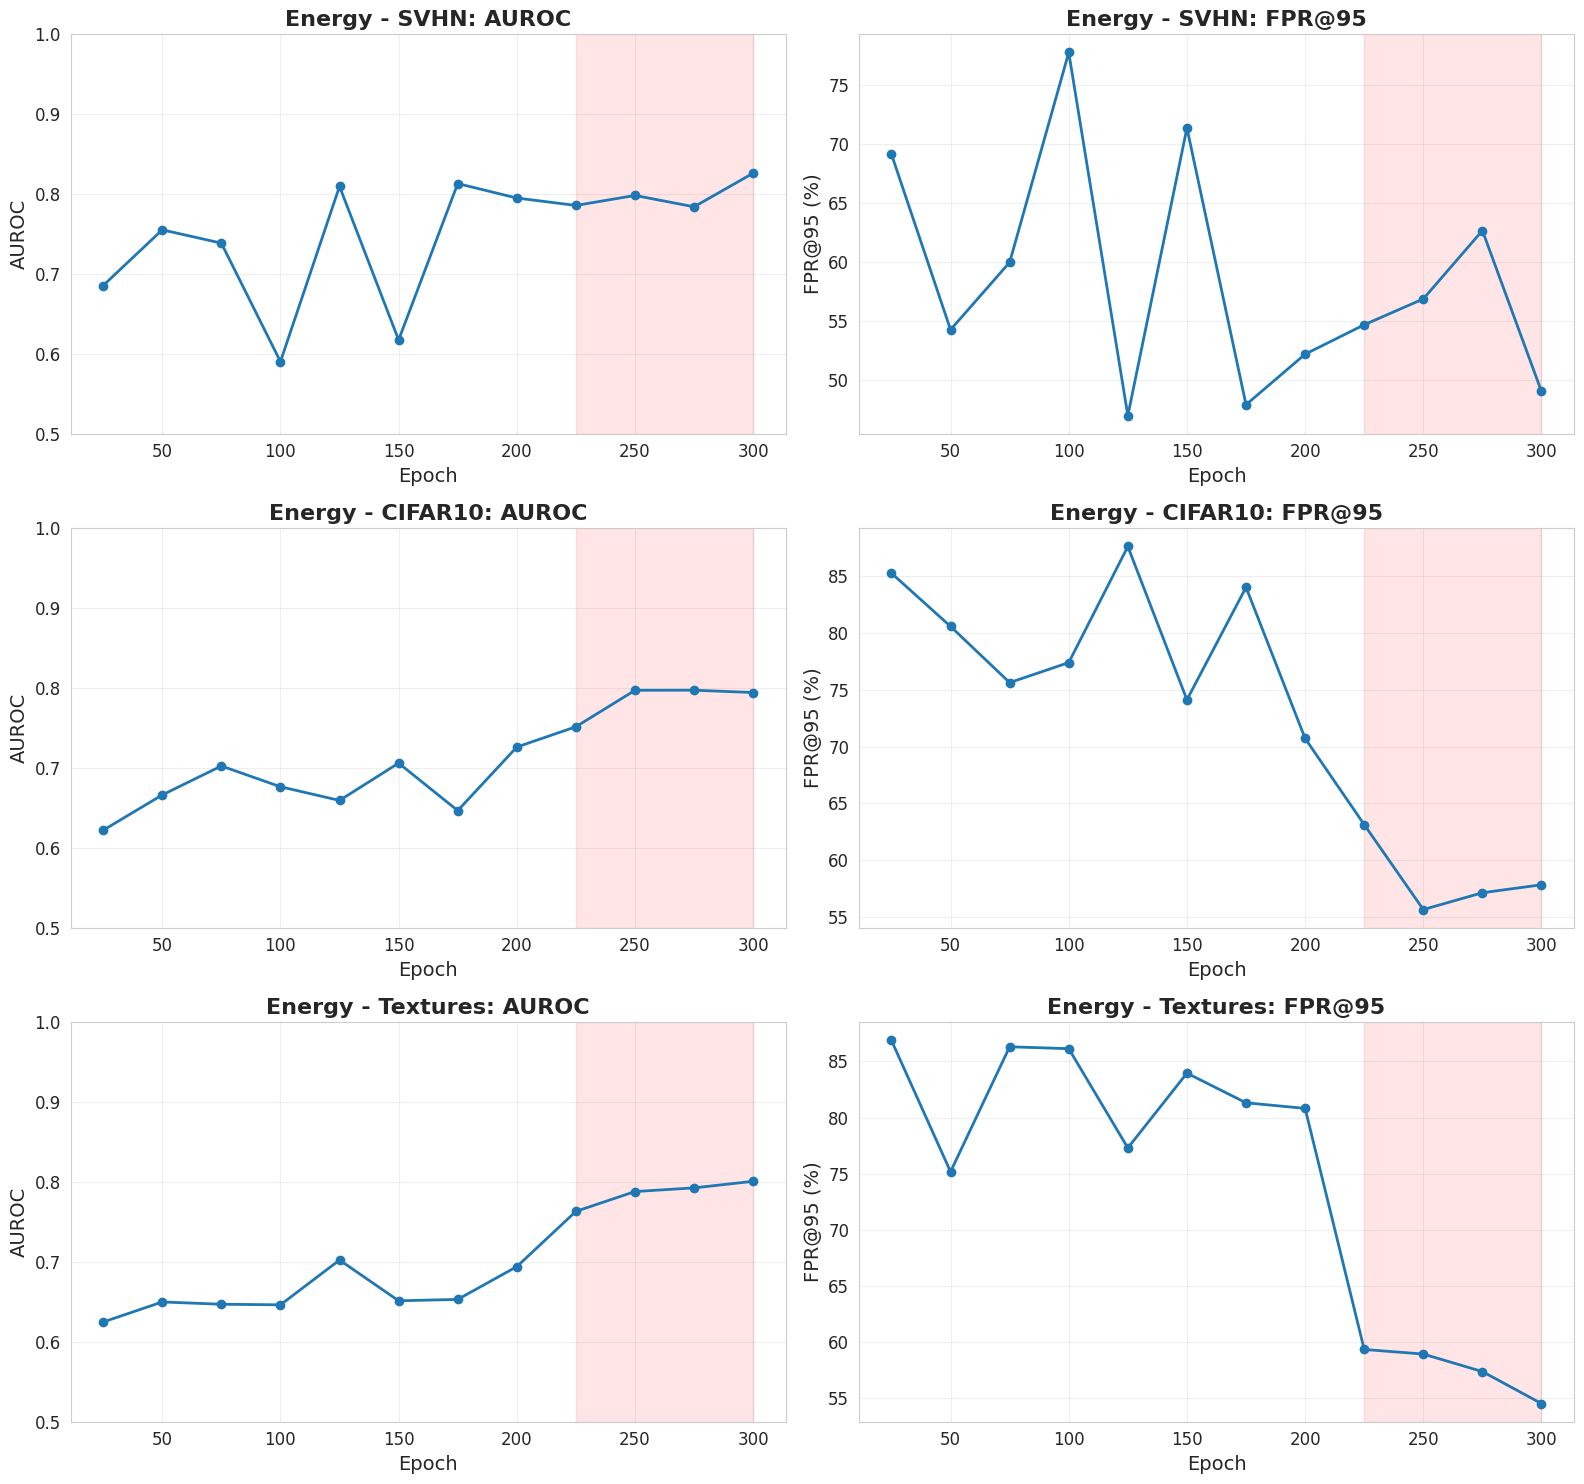

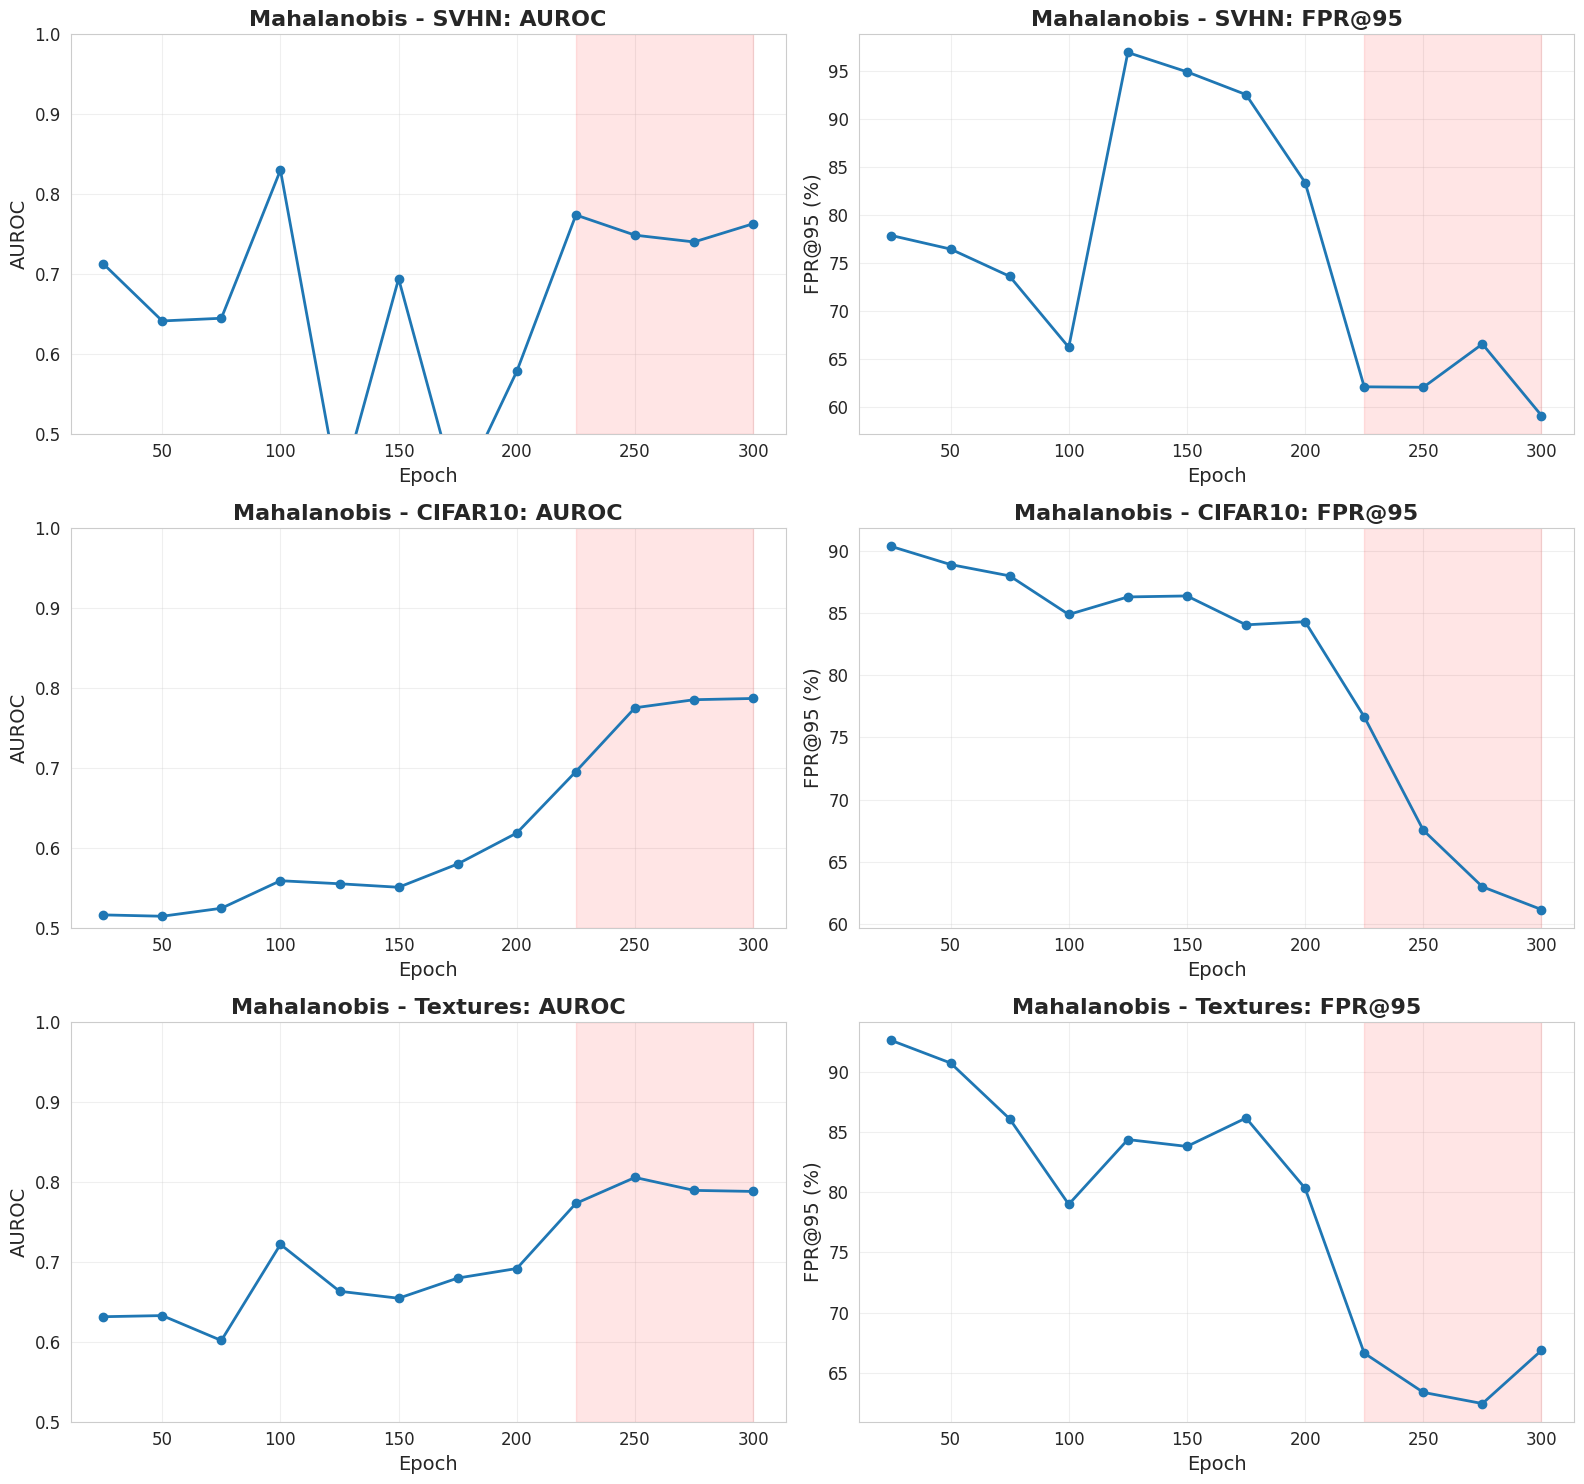

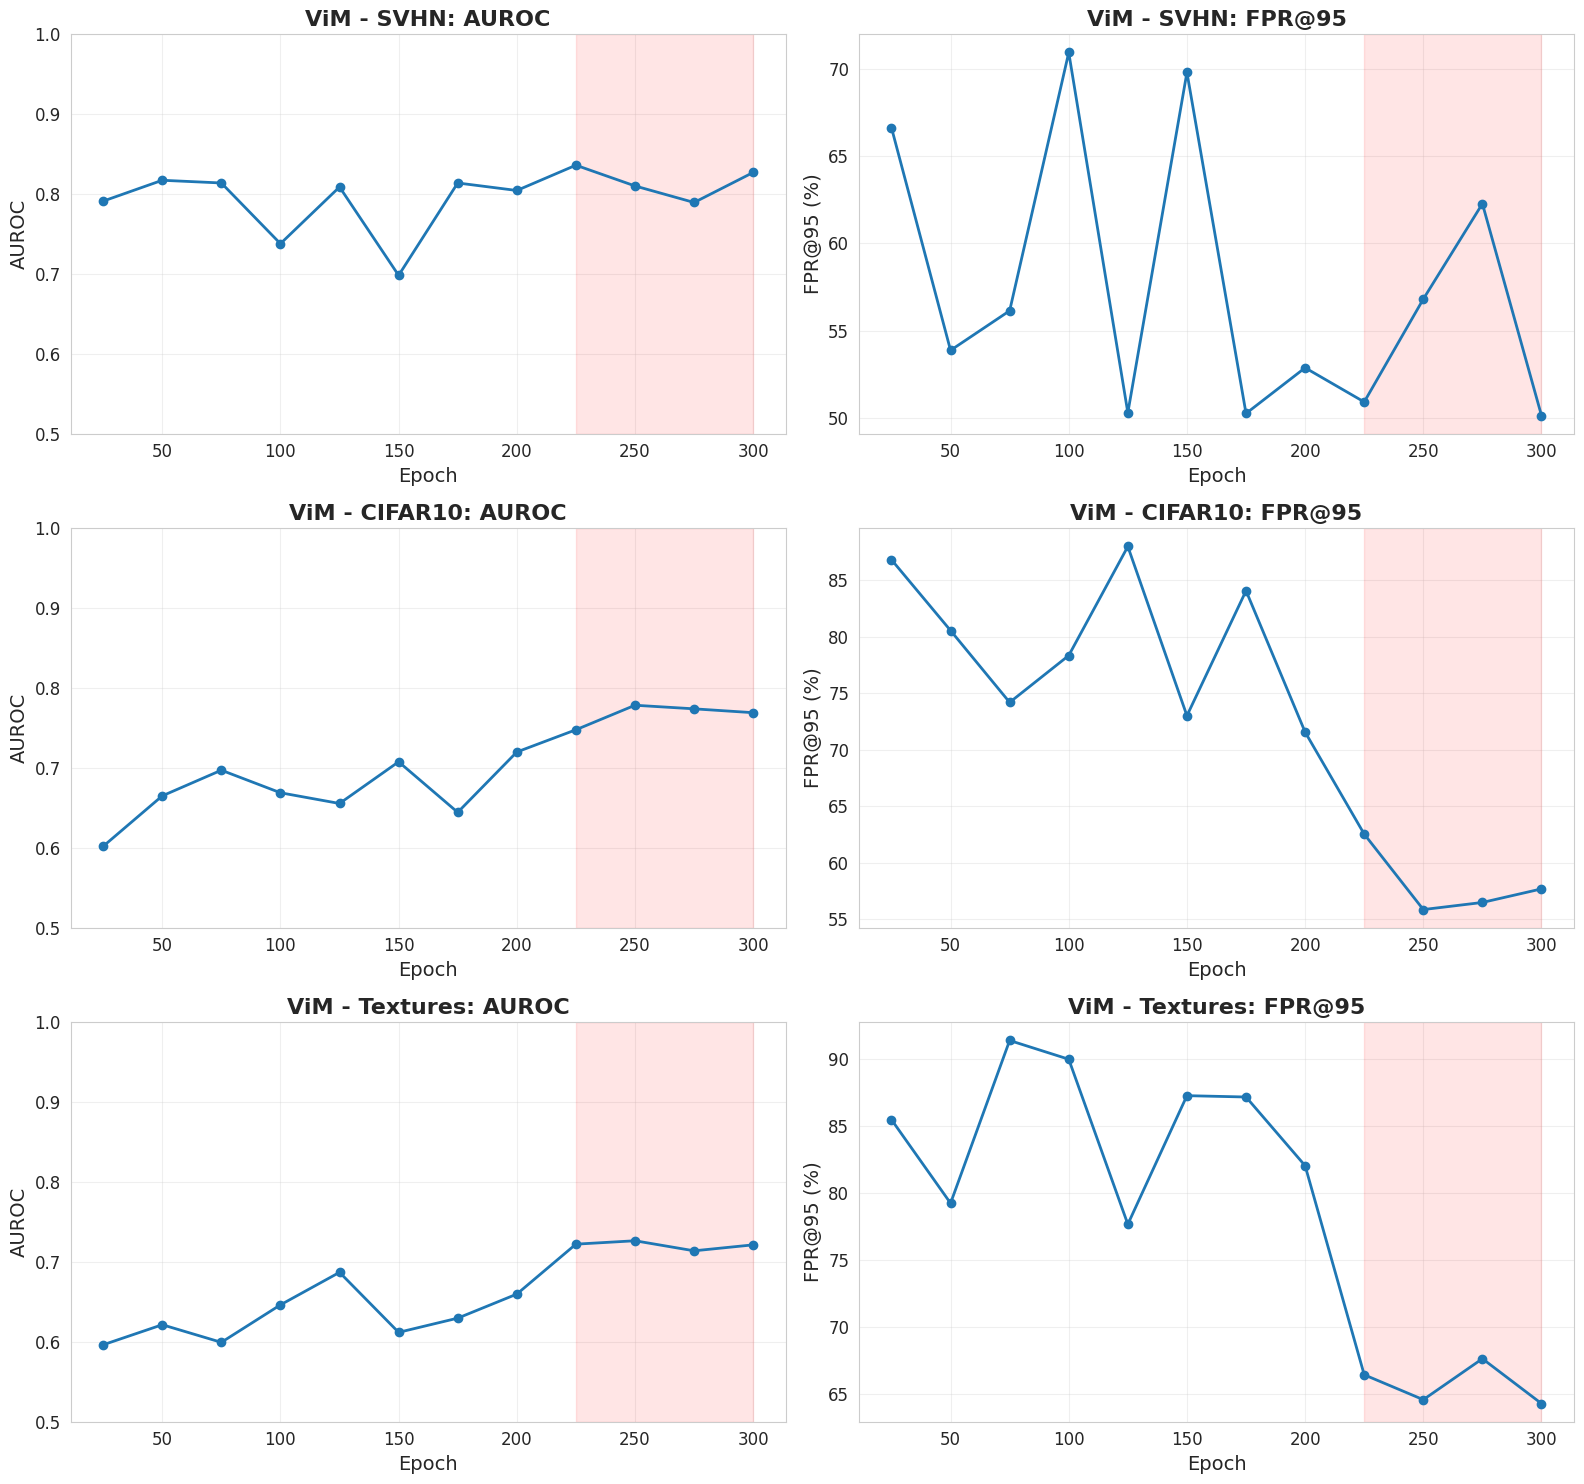

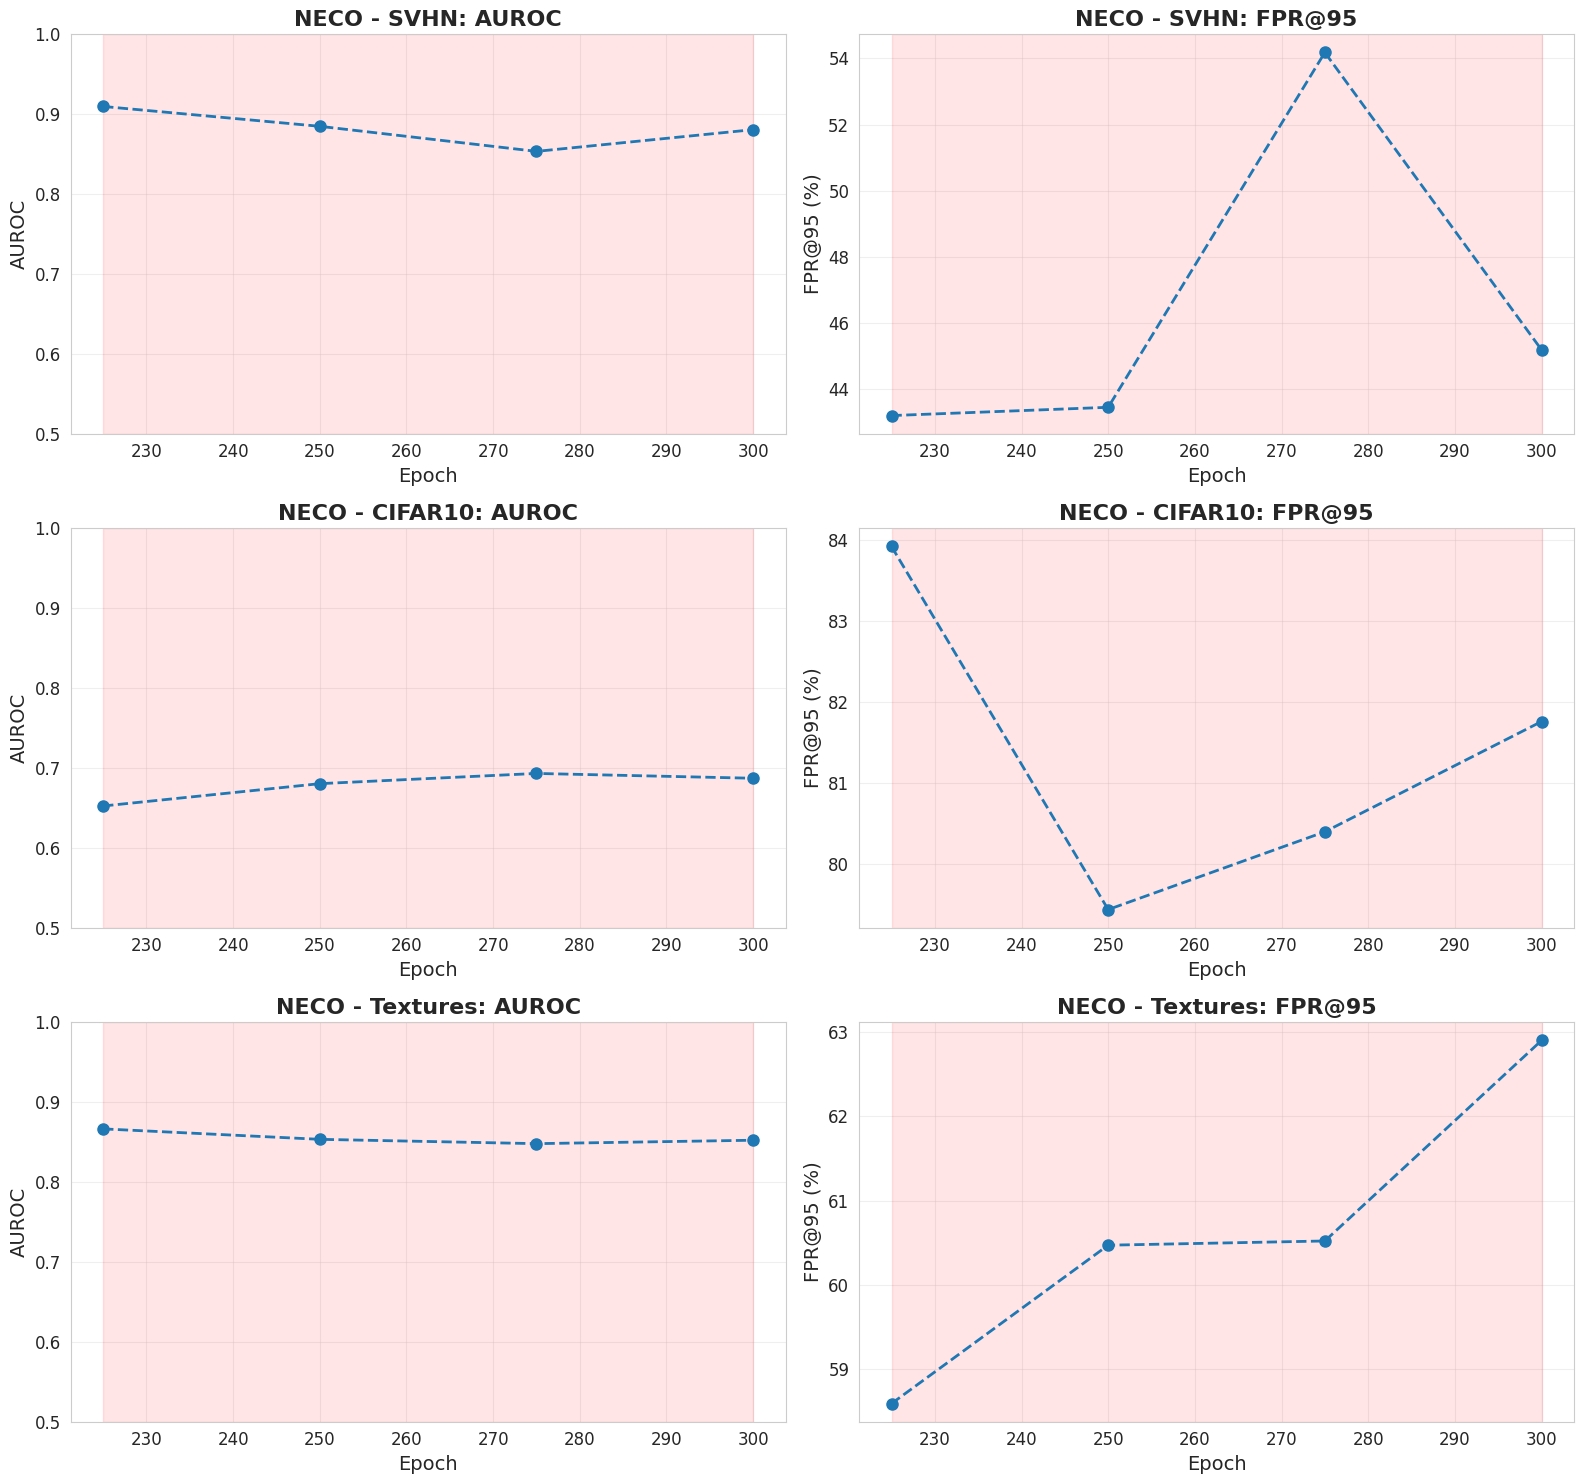


OOD Detection Evaluation Complete!


In [13]:
plot_ood_scores_per_dataset(results, save_dir=output_dir)

print("\n" + "="*60)
print("OOD Detection Evaluation Complete!")
print("="*60)